In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
## This prevents execution of lengthy grid search at the end of notebook. 
## A shorter taking around six minutes grid search will still be executed.     
RUN_GRID_SEARCH = False

# Text classification - Multinomial Bayes

Bayes classifier  is often used in text classification e.g. for sentiment analysis or spam recognition. It assumes the so called "bag of words model". In this approach we treat a document as an unordered colllection of words (tokens) and only count the number of times each word was used in the document. The list of all worlds that we  consider is called the _vocabulary_. 

We treat the vocabulary as __one__ giantic categorical feature $X$. Then each document of length $n$ can be viewed as  draw from the multinomial distribution i.e. we select _with replecement_ $n$ words at random from the vocabulary. For more information see the references below.

### References 
 1. A. McCallum and K. Nigam (1998). [A comparison of event models for Naive Bayes text classification](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.46.1529). Proc. AAAI/ICML-98 Workshop on Learning for Text Categorization, pp. 41-48.
 1. V. Metsis, I. Androutsopoulos and G. Paliouras (2006). [Spam filtering with Naive Bayes – Which Naive Bayes?](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.61.5542) 3rd Conf. on Email and Anti-Spam (CEAS).


## Training

## "Bag of words" model

$$\begin{vmatrix}
  & | & 0 & 1 & 2 & \cdots & n_{w}-1   \\\hline
0 & | & 0 & 2 & 0 & \cdots & 0\\  
1 & | & 1 & 1 & 0 & \cdots & 3\\  
\vdots && \vdots & \vdots &\vdots&\ddots& \vdots\\
n_s-1 & | & 0 & 1 & 0 & \cdots & 0
\end{vmatrix}$$

Our training data will consist of number of  documents with labels assigning them to $n_c$ different classes. 

We start by converting documents  into vectors. Each element of the vector corresponds to one word in the vocabulary and contains the number of times this word was used in the document. If $n_s $ is the number of documents(samples) nad $n_w$ is the number of words in the vocabulary then our data can be represented as $n_s\times n_w$ matrix $\mathbf{X}$ and  $y_i=0,\ldots,n_c-1$ will represent  corresponding class label. 

Let $m_i$ denote the  number of words in document $i$

$$m_i = \sum_{j=0}^{n_w-1} X_{ij}$$

The total number of times the ith word was used in documents belonging to class $c$  will be denoted by $n^{(c)}_i$

$$n^{(c)}_i= \sum_{j=0}^{n_s-1} X_{ji}\delta_{y_j,c},
\qquad \delta_{a,b}=  \begin{cases}
1 & a=b\\
0 & a\neq b
\end{cases}
$$

The total number of worlds in documents in class $c$ will be denoted by $n^{c}$.

$$n^{(c)}= \sum_{i=0}^{n_w-1} n^{(c)}_i = \sum_{i=0}^{n_w-1}\sum_{j=0}^{n_s-1} x_{ji}\delta_{y_j,c}
$$

Then the smoothed estimator of the conditional probability that word $i$ will be used in document belonging to class $c$

$$P(i|c)$$

is 

$$
p^{(c)}_{i} = \frac{n^{(c)}_i+\alpha}{n^{(c)}+n_w \alpha}, \quad \alpha\ge 0
$$

Once the $p^{(c)}_i$  are estimated we can estimate the conditional probability the whole  vector $\mathbf{X}_j$   given by the multinomial distribution

$$P(\mathbf{X}_j|C=c)
=
\frac{n^{(c)}!}{\prod_{i=0}^{n_w-1} (n_i^{(c)}!)}
\prod_{i=0}^{n_w-1} \left(p^{(c)}_i\right)^{\displaystyle X_{ji}}$$

In practice most of the $X_{ji}$ are zero and sums and products in the above expression have range only over the number of unique tokens in the document. 

Finally using Bayes theorem we obtain 

$$P(C=c|\mathbf{X}_j) = \frac{P(\mathbf{X}_j|C=c)P(C=c)}{\sum_c P(\mathbf{X}_j|C=c)P(C=c)}$$

## Amazon reviews

We will use the Amazon review data set. This data set is very handy because it contains both documents (reviews) and labels (ratings). We can use it to train classifier predict ratings based on the review. The original data set is HUGE  and can be  _e.g._ found [here](http://jmcauley.ucsd.edu/data/amazon/). We will use the preprocessed data from [amazon_review_full.tar.gz](https://drive.google.com/file/d/0Bz8a_Dbh9QhbZVhsUnRWRDhETzA/view?usp=sharing) file on
[ Xiang Zhang's Google Drive dir](https://drive.google.com/open?id=0Bz8a_Dbh9Qhbfll6bVpmNUtUcFdjYmF2SEpmZUZUcVNiMUw1TWN6RDV3a0JHT3kxLVhVR2M). However it still has 1.5GB of data when uncompressed. So for the sake of this lecture I have prepared a smaller sample that I have additionally compressed with 'bz2' reducing the size to "only" 41MB. You can play with original file by downloading it directly from the link above. 

The data was selected using the code below. 

```python
from sklearn.model_selection import train_test_split
seed = 85865
data = pd.read_csv("../../Data/amazon_reviews/amazon_review_full_csv/train.csv",
                   names=["rating", "title", "review"])
small_data,_ = train_test_split(data,train_size=300000,  stratify=data['rating'], random_state=seed)
small_data.to_csv("../../Data/amazon_reviews/small.csv.bz2", index=False, compression='bz2')
```

Use of the 'stratify' argument  guarantee that proportion of each ratings will be  preserved. In this case we will have same number of documents with each rating. The smaller file can be read in using:

In [4]:
data = pd.read_csv("../../Data/amazon_reviews/small.csv.bz2", compression='bz2')

In [5]:
data.head(3)

,rating,title,review
0,2,"Way too dumbed down, even for fun history read...","True, I did want a fun historical read, a samp..."
1,2,Too Narrow and no Wide option,I am returning these shoes as they are too nar...
2,3,Disappointing,"I actually prefer their first book, which at l..."


The file contains

In [6]:
len(data)

300000

reviews. We will split this set into training and testing sets: 

In [7]:
seed = 57576
train_data, test_data = train_test_split(data,train_size=250000, test_size=50000, stratify=data['rating'], random_state = seed)

We can check that indeed we have equal number of documents for each rating. 

In [8]:
train_data.rating.value_counts()

1    50000
2    50000
3    50000
4    50000
5    50000
Name: rating, dtype: int64

In [9]:
test_data.rating.value_counts()

1    10000
2    10000
3    10000
4    10000
5    10000
Name: rating, dtype: int64

In [10]:
train_data.head(5)

,rating,title,review
266164,3,not for all homeschoolers,I bought this for my 4th grade daughter (homes...
178470,2,Basically a bragging biography of the author's...,The information in this book would consist of ...
271121,5,Better questions lead to better results,As a psychologist I understand the importance ...
39119,5,Great shoes,I really like these shoes! They have just the ...
281417,2,It was midly interesting,It was okay but I definately don't reccomend a...


## Extracting features

The next step is to convert each document into vector as described in the introduction.  This is actually a non trivial task. It requires first spliting text into _tokens_ (e.g. words). Not all letter combinations are meaningfull and we have decide which tokens are valid. Also it may be advantageous to  do _steming_: reduce the word to its _root_ word e.g. 'flying'->'fly. 

The scikit-learn library contains a [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) class that implements a simple tokenizer and occurence counting.

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

In [12]:
vectorizer = CountVectorizer(stop_words='english')

You should consult the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)  for the full description of the available arguments. I used only one: `stop_words = 'english'` which enables the use of the internal list of tokens to reject (stop words) (but see  [the description here](https://scikit-learn.org/stable/modules/feature_extraction.html#stop-words)). 

The method `fit_transform` takes the dataset and prepares the vocabulary and then encodes the dataset. It's a  composition of `fit` and `transform` methods.

In [13]:
%%time
review_features = vectorizer.fit_transform(train_data.review)

CPU times: user 10.6 s, sys: 192 ms, total: 10.8 s
Wall time: 10.8 s


In [14]:
review_features.shape

(250000, 191164)

As we can see the resulting matrix is huge!! And it's a  only a small version of data... But even this "small" version would take 

In [15]:
np.prod(review_features.shape)/2**30

44.508837163448334

gigabytes of data assuming only one byte of data per entry. However each document contains only a very small subset of total vocabulary. So each row of this matrix contains mostly zeros e.g. in first five rows it is:

In [16]:
np.count_nonzero(review_features[:5,:].toarray(), axis = 1)

array([27, 47, 63, 11, 18])

compared to 

In [17]:
review_features.shape[1]

191164

row length. That's why it is stored in the compressed matrix format

### Sparse matrices

In [18]:
type(review_features)

scipy.sparse.csr.csr_matrix

and we had to  use `toarray` method above to convert it to normal numpy array. Be carefull not to call this methods on the whole matrix!!!

The `nnz` attribute stores the number of actuall entries in the matrix

In [19]:
review_features.nnz

7480565

Resulting in only  small proportion of all the entries

In [20]:
review_features.nnz/np.prod(review_features.shape)

0.0001565266472766839

In [21]:
price_i = vectorizer.vocabulary_['price']
print(price_i)

132758


In [22]:
vectorizer.get_feature_names()[price_i]

'price'

The vectorizer object stores the `vocabulary_` dictionary that maps words to   vector indices. 

and word list that does the oposite:

## Classification

We will again use the invaluable scikit-learn library which implements the Multinomial classifier. 

In [23]:
from sklearn.naive_bayes import MultinomialNB

In [24]:
base_rating_classifier = MultinomialNB()

In [25]:
base_rating_classifier.fit(review_features, train_data.rating)

MultinomialNB()

In [26]:
%%time
test_features = vectorizer.transform(test_data.review)

CPU times: user 1.97 s, sys: 18.8 ms, total: 1.99 s
Wall time: 2 s


In [27]:
base_rating_classifier.score(test_features, test_data.rating)

0.43456

In [28]:
from sklearn.metrics import accuracy_score

In [29]:
base_predicted =  base_rating_classifier.predict(test_features)

In [30]:
accuracy_score(test_data.rating, base_predicted)

0.43456

The `score` method implements the acccuracy metric which  gives the percentage of correct classfications. 

The accuracy does not look very good but keep in mind that  this is not binary classification.  We have five  ratings so random guessing would give us accuracy around 20%.  All the scores we have introduced in the 'categorical' notebook give similar (or identical) results. 

In [31]:
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_fscore_support, classification_report

In [32]:
print(classification_report(test_data.rating, base_predicted, digits=3))

              precision    recall  f1-score   support

           1      0.496     0.603     0.544     10000
           2      0.361     0.356     0.359     10000
           3      0.354     0.319     0.336     10000
           4      0.392     0.328     0.357     10000
           5      0.534     0.567     0.550     10000

    accuracy                          0.435     50000
   macro avg      0.427     0.435     0.429     50000
weighted avg      0.427     0.435     0.429     50000



In [33]:
precision_recall_fscore_support(test_data.rating, base_predicted, average='macro')

(0.4274804399940919, 0.43456, 0.42912122517647433, None)

In [34]:
def plot_results(true_ratings, predictated_ratings):
    fig, ax = plt.subplots(1,3, figsize=(18,5))
    diffs = predictated_ratings - true_ratings
    ax[0].hist(diffs, bins=9, range=(-4.5,4.5), density=True);
    ax[0].set_xlabel("$\delta$")
    ax[0].set_ylabel("$P(\Delta r = \delta)$")
    ax[1].hist(np.abs(diffs), bins=5, range=(-0.5,4.5), density=True);
    ax[1].set_xlabel("$\delta$")
    ax[1].set_ylabel("$P(|\Delta r| = \delta)$")

    ax[2].hist(np.abs(diffs), bins=5, range=(-0.5,4.5), density=True, cumulative=True, histtype='step');
    ax[2].axhline(0.80, linewidth=0.75, color='grey');
    ax[2].set_xlabel("$\delta$")
    ax[2].set_ylabel("$P(\Delta r \leq \delta)$", fontsize=12)

Accuracy counts only the ratings we got exactly right. However we are not dealing with real categorical (nominal) data. Our labels are _ordinals_ meaning that there is an order to ratings  and clearly predicting one instead of five is a bigger error then predicting four. In practice we may tolerate  _e.g._  to be one rating off.

Let's look more closely how close we are with our classification.
The function below calculates the histogram of differences between  predictions and true ratings and plots it. 

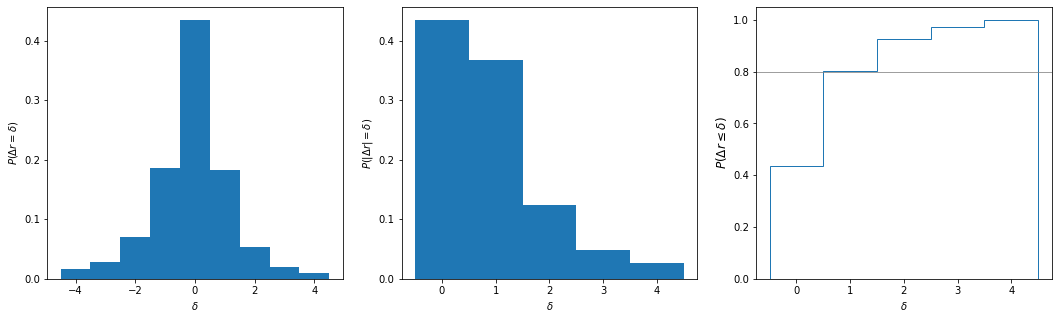

In [35]:
plot_results(test_data.rating, base_predicted)

We see that im 80% of cases we are just one rating off.

We can get  similar results  with `confusion_matrix` functions from scikit-learn

In [36]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

Please pay attention to `normalize` parameter. This displays  the relative frequencies of all possible outcomes combinations:   rows correspond to true labels, columns to predicted.

In [37]:
outcome_freq = confusion_matrix(test_data.rating, base_predicted, normalize='all')
outcome_freq

array([[0.12054, 0.04566, 0.0173 , 0.00656, 0.00994],
       [0.05676, 0.07128, 0.04498, 0.01444, 0.01254],
       [0.03072, 0.04652, 0.06374, 0.03716, 0.02186],
       [0.01782, 0.0234 , 0.03852, 0.06554, 0.05472],
       [0.01704, 0.0107 , 0.01534, 0.04346, 0.11346]])

It ads up to one as expected

In [38]:
outcome_freq.sum()

1.0

We can get the counts of each outcomes by not requesting normalization

In [39]:
confusion_matrix(test_data.rating, base_predicted)

array([[6027, 2283,  865,  328,  497],
       [2838, 3564, 2249,  722,  627],
       [1536, 2326, 3187, 1858, 1093],
       [ 891, 1170, 1926, 3277, 2736],
       [ 852,  535,  767, 2173, 5673]])

scikit-learn provides also function for plotting  confusion matrix.

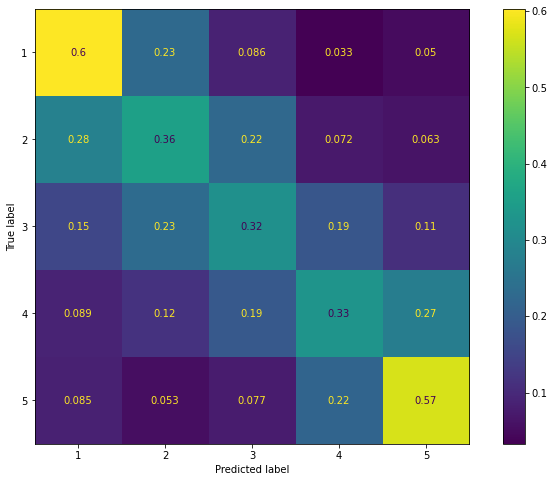

In [40]:
fig, ax = plt.subplots(figsize=(12,8))
disp = plot_confusion_matrix(base_rating_classifier, test_features, test_data.rating, normalize='true', ax=ax);

 The normalization set to 'true' normalizes each row separately. We can check this by accesing the computed confusion matrix.

In [41]:
disp.confusion_matrix.sum(axis=1)

array([1., 1., 1., 1., 1.])

We can see that the most extreme ratings are most often  predicted correctly, which maybe is not that suprising. 

If we want to display an already computed confusion matrix we can use the `ConfusionMatrixDisplay` class

Text(0, 0.5, 'true ratings')

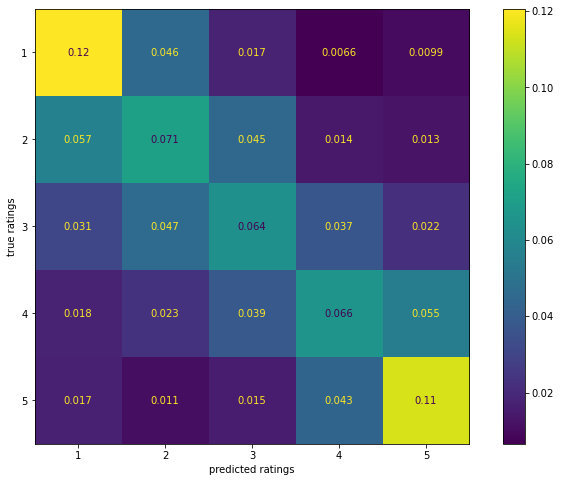

In [42]:
from sklearn.metrics import ConfusionMatrixDisplay
cm_display = ConfusionMatrixDisplay(outcome_freq, display_labels=range(1,6))
fig, ax = plt.subplots(figsize=(12,8))
cm_display.plot(ax=ax);
ax.set_xlabel('predicted ratings')
ax.set_ylabel('true ratings')

#### Most probable words

Let's look what are the most probable words in each category. The MultinomialNB makes the  logs of probabilities

$$\log P(X_i=i|R=r)=\log p^{(r)}_{i}$$

available as `feature_log_prob_` attribute. We can extract the index of highest number in an array using numpy function `argmax`

In [43]:
most_probable = np.argmax(base_rating_classifier.feature_log_prob_,axis=1)
most_probable

array([25614, 25614, 25614, 25614, 25614])

To convert the indices to word in the vocabulary we will use an auxiliary function

In [44]:
def word(i):
    return vectorizer.get_feature_names()[i]

word = np.vectorize(word)

The numpy `vectorize` function takes a Python function and makes it _threadable_ over numpy arrays, but please note that this may be quite inneficient. 

In [45]:
word(most_probable)

array(['book', 'book', 'book', 'book', 'book'], dtype='<U4')

In [46]:
a = np.random.uniform(0,1,6)
print(a)
ia = np.argsort(a)
print(ia)
print(a[ia])

[0.76747753 0.89836094 0.86719317 0.02347942 0.20340148 0.39881874]
[3 4 5 0 2 1]
[0.02347942 0.20340148 0.39881874 0.76747753 0.86719317 0.89836094]


Below we take $n$ most probable words  for each rating

We can look at more words using the `argsort` function which returns the indices of the array in the sorted by (ascending) values order

In [47]:
n = 20 
most_probable = np.argsort(base_rating_classifier.feature_log_prob_,axis=1)[:,-1:-n-1:-1]

`argsort` sorts in ascending order. To list last $n$ elements of an array  in reverse order we use  slice with negative stride. 

`[-1:-n-1:-1]` means: start from last element (first from the end) and  go down  to  but not including n+1 element from the end. 

In [48]:
words = word(most_probable)

We can use Pandas dataframe to "pretty print" the  resulting array

In [49]:
pd.DataFrame(words, index =[1,2,3,4,5], columns=range(1,21))

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
1,book,just,like,don,time,good,movie,product,money,buy,read,bought,did,work,really,bad,use,better,got,waste
2,book,like,just,good,really,time,don,read,movie,better,great,did,use,bought,work,way,does,story,didn,buy
3,book,good,like,just,great,really,read,movie,time,don,better,little,story,think,does,did,use,album,work,way
4,book,good,great,like,just,read,really,time,movie,little,love,album,use,story,don,cd,think,better,does,best
5,book,great,like,just,read,good,love,time,best,really,cd,movie,album,music,ve,recommend,use,story,years,don


## Hyperparameters tuning

While developing the text classifier above we had to set  a number of parameters. The `MultinomialNB` has only  one: `alpha`, but   vectorizer has several. Those parameters are called _hyperparameters_ to distinguish them from the parameters like $p^{(r)}_i$  that we are training. It is not clear a priori  what values of those hyperparameters will give us the best results. Unfortunatelly here we  are moving away from nice science of probability calculus  and enter the realm  of black magic of hyperparameters tuning.  

The most obvious and conceptually easiest strategy is the search of the space of possible parameters. In practice this is of course not possible, but we can at least scan a part of the parameters space and get some feeling about performance. 

Before we begin we must however think a little bit about how are we going to measure the performance of  the classifier. I have already stated that we must not use the training set for evaluation. What about the testing set then? While not so obvious, when we are tuning the hyperparameters we are also in some sense training our model. So if we use the test set to choose best hyperparameters we cannot use this set for overall final evaluation. The solution is to  set aside yet another set called the _validation_ dataset and use this set for tuning hyperparameters. For more explanation see [this article](https://machinelearningmastery.com/difference-test-validation-datasets/).

### Cross validation

Unfortunatelly  we usually have a finite amount of data and leaving aside test and validatation sets leaves less data for training. One of the strategies used to mitigate that is _k-fold cross validation_. This works like that: We divide our data in $k$ equal parts called folds.  Then we train our model $k$ times each time using different fold for testing and $k-1$ remaining folds for training. That way we get $k$ evaluations results that we can e.g. average. 

Fortunatelly scikit-learn  provides several functions to help us with cross validation.

In [50]:
from sklearn.model_selection import cross_val_score, cross_validate

In [51]:
for a in [0,1,2,3,4,5,10,20,30,50]:
    scores = cross_val_score(MultinomialNB(alpha=a), review_features, train_data.rating,cv = 5, n_jobs=-1 )
    print("{:4.1f} {:6.4f}".format(a, scores.mean()), scores)

 0.0 0.3805 [0.38456 0.37798 0.3768  0.38042 0.38284]


 1.0 0.4319 [0.43612 0.42952 0.42716 0.4326  0.43416]


 2.0 0.4346 [0.43864 0.4329  0.43104 0.43534 0.43518]


 3.0 0.4356 [0.43954 0.43406 0.43284 0.43566 0.43582]


 4.0 0.4356 [0.4398  0.43444 0.43312 0.43498 0.43552]


 5.0 0.4352 [0.43976 0.43422 0.43386 0.43392 0.43418]


10.0 0.4312 [0.43492 0.4306  0.43188 0.4296  0.42906]


20.0 0.4263 [0.42992 0.4256  0.4267  0.42628 0.4228 ]


30.0 0.4233 [0.42656 0.42226 0.42458 0.4237  0.4195 ]


50.0 0.4192 [0.42076 0.41884 0.42062 0.42006 0.41574]


The `cross_val_score` function can run its  training and scoring tasks concurrently. This is enabled by the `n_jobs` parameter  which indicated the number of concurrent processes we want to use. Be default this is `None` which is equvalent to one (no concurrency). Setting   it to -1 results in  automatic determination of number of processes to run and on computers with hyperthreading this will 
be twice the number of cores. For such small jobs as above this does not matter. But for larger jobs you should try different values of this parameter. Not always more processes is the better!

By deafult `cross_val_score` uses `score` function of the estimator which in this case was the accuracy score. We may change this by providing  `scoring` parameter

In [52]:
for a in [0,1,2,3,4,5,10,20,30,50]:
    scores = cross_val_score(MultinomialNB(alpha=a), review_features, train_data.rating,cv = 5, n_jobs=-1, scoring='f1_macro' )
    print("alpha = {:4.1f} {:6.4f}".format(a, scores.mean()), scores)

alpha =  0.0 0.3778 [0.38199208 0.37528732 0.37386233 0.37788722 0.38006499]


alpha =  1.0 0.4269 [0.43113326 0.4246196  0.42185249 0.42778567 0.4291477 ]


alpha =  2.0 0.4315 [0.43550954 0.42982213 0.42775563 0.43239242 0.43208676]


alpha =  3.0 0.4341 [0.43791825 0.43258124 0.43106893 0.43442646 0.4343987 ]


alpha =  4.0 0.4353 [0.43947284 0.4341402  0.43258275 0.43502213 0.43520397]


alpha =  5.0 0.4358 [0.44033065 0.43489794 0.4342977  0.43481308 0.43479187]


alpha = 10.0 0.4340 [0.43762666 0.43347557 0.43467454 0.43249273 0.43171432]


alpha = 20.0 0.4296 [0.43326562 0.4289125  0.43024814 0.42974962 0.42597149]


alpha = 30.0 0.4265 [0.42980617 0.42532777 0.42791613 0.4269143  0.42238618]


alpha = 50.0 0.4219 [0.42362596 0.42133877 0.42350171 0.42282405 0.41817308]


Function `cross_validate` does the same but allows for multiple metrics  and reports more information _e.g._ time used for fit and scoring. 

In [53]:
cross_val_results = cross_validate(MultinomialNB(alpha=20), review_features, train_data.rating,cv = 5, n_jobs=-1, scoring=['accuracy', 'f1_macro', 'precision_macro'] )

`cross_validata` returns its results in  format suitable for directly using it in pandas  dataframe which resulst in nicer output

In [54]:
pd.DataFrame(cross_val_results)

,fit_time,score_time,test_accuracy,test_f1_macro,test_precision_macro
0,0.198630,0.069675,0.42992,0.433266,0.457641
1,0.211211,0.092757,0.42560,0.428912,0.453154
2,0.235862,0.071976,0.42670,0.430248,0.453788
3,0.243671,0.061146,0.42628,0.429750,0.454511
4,0.236119,0.067014,0.42280,0.425971,0.452960


### Grid search

In case of bigger number of different parameters writing our explicit search loops like above can be tedious. We can use the `GridSearchCV` class to combine search with cross validation.

In [55]:
from sklearn.model_selection import GridSearchCV

In [56]:
param_grid = {'alpha': [0,1,2,3,4,5,10,20,30,40,50,60]}

In [57]:
grid_search = GridSearchCV(MultinomialNB(), param_grid=param_grid, n_jobs=6, cv=5, scoring='f1_macro')

In [58]:
%%time
grid_search.fit(review_features, train_data.rating)

CPU times: user 404 ms, sys: 250 ms, total: 654 ms
Wall time: 7.46 s


GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=6,
             param_grid={'alpha': [0, 1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 60]},
             scoring='f1_macro')

The search results are reported in `cv_results_` attribute which can be  used directly  to construct a dataframe

In [59]:
pd.DataFrame(grid_search.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,0.192622,0.025931,0.045009,0.006259,5,{'alpha': 5},0.440331,0.434898,0.434298,0.434813,0.434792,0.435826,0.002262,1
4,0.199817,0.032881,0.039438,0.003407,4,{'alpha': 4},0.439473,0.434140,0.432583,0.435022,0.435204,0.435284,0.002290,2
3,0.239651,0.003753,0.054683,0.004636,3,{'alpha': 3},0.437918,0.432581,0.431069,0.434426,0.434399,0.434079,0.002292,3
6,0.247175,0.012876,0.046905,0.007500,10,{'alpha': 10},0.437627,0.433476,0.434675,0.432493,0.431714,0.433997,0.002068,4
2,0.224818,0.011710,0.049853,0.005602,2,{'alpha': 2},0.435510,0.429822,0.427756,0.432392,0.432087,0.431513,0.002610,5
7,0.208703,0.026036,0.049957,0.005545,20,{'alpha': 20},0.433266,0.428912,0.430248,0.429750,0.425971,0.429629,0.002346,6
1,0.256699,0.034318,0.053458,0.003222,1,{'alpha': 1},0.431133,0.424620,0.421852,0.427786,0.429148,0.426908,0.003300,7
8,0.226950,0.015044,0.048950,0.006238,30,{'alpha': 30},0.429806,0.425328,0.427916,0.426914,0.422386,0.426470,0.002506,8
9,0.242415,0.007278,0.052390,0.005775,40,{'alpha': 40},0.426554,0.422547,0.425360,0.424397,0.420039,0.423779,0.002284,9
10,0.205913,0.019067,0.046865,0.004854,50,{'alpha': 50},0.423626,0.421339,0.423502,0.422824,0.418173,0.421893,0.002030,10


The `fit` method by deafult selects the best set of paramters according to scoring metric and refits the estimator to all data using those parameters. The resulting object is stored in `best_estimator_` attribute

In [60]:
best_clf = grid_search.best_estimator_
best_predicted = best_clf.predict(test_features)

In [61]:
f1_score(test_data.rating, best_predicted, average='macro' )

0.4380273545266851

Comparing to the "base" accuracy

In [62]:
acc_best = accuracy_score(test_data.rating, best_predicted)
acc_base = accuracy_score(test_data.rating, base_predicted)
print("base {:.3f} best {:.3f} diff {:.3f} rel diff {:3.0f}%".format(acc_base, acc_best, acc_best-acc_base,100*(acc_best-acc_base)/acc_base))

base 0.435 best 0.438 diff 0.004 rel diff   1%


In [63]:
def evaluate_metrics(data, label, estimator, metrics):
        result={}
        predicted = estimator.predict(data)
        for name, func in metrics.items():
            result[name]= func(label, predicted)
        return result    
        
def evaluate_estimators_on_metrics(data, labels, estimators, metrics):
    results = {}
    
    for name, est in estimators.items():
        results[name] = evaluate_metrics(data, labels, est, metrics)
        
    return results     
            
def compare_to(evaluation,base):
    result = {}
    base_res = evaluation[base]
    for m_name, m in base_res.items():
            metric_column = result.setdefault('metric',[])
            metric_column.append(m_name)
            base_m_column = result.setdefault(base,[])
            base_m_column.append(m)
            for e_name, res in evaluation.items():
                if e_name != base:
                    m_column = result.setdefault(e_name,[])
                    current = evaluation[e_name]
                    m_value = current[m_name]
                    m_column.append(m_value)
                    column = result.setdefault(e_name+'_diff',[])
                    column.append(m_value-m)
                    column = result.setdefault(e_name+'_rel',[])
                    column.append((m_value-m)/m)
                    
                    
    return  result     
                
    

In [64]:
f1_macro = lambda x,y: f1_score(x,y, average = 'macro')

We see a very slight increase in accuracy.  This does not seem as a lot and for this particular example it isn't. But for some applications if accuracy translates  e.g. directly to our profit this gives us a 1% increase "for free". 

In [65]:
pd.DataFrame(
    compare_to(
        evaluate_estimators_on_metrics(test_features, test_data.rating, {'base': base_rating_classifier, 'best' :best_clf}, {'accuracy': accuracy_score, 'f1_macro': f1_macro}),
        'base')
)

,metric,base,best,best_diff,best_rel
0,accuracy,0.434560,0.438280,0.003720,0.008560
1,f1_macro,0.429121,0.438027,0.008906,0.020754


### Pipelines

This is based on  scikit-learn : [Working with text data](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html) example.

Now we would like to optimize also the parameters of the `CountVectoriser`, but `GridSearchCV`accepts a single estimator object as input. We could write a  class that combines together `CountVectoriser` and `MultinomialNB` but we don't have to :) Scikit-learn provides an easy way to do it using it's `Pipeline` class. 

In [66]:
from sklearn.pipeline import Pipeline

In [67]:
rating_clf_pipe =  Pipeline([('vect', CountVectorizer(stop_words='english', max_df=0.25, min_df=10, max_features=None)),
                       ('clf', MultinomialNB())])

This creates a  `Pipeline` object that has all the methods of the estimator object. The pipeline can consist of several transformer objects and an estimator object at the end (see [documentation](https://scikit-learn.org/stable/developers/develop.html) for description of estimators and other interfaces). The resulting object accepts data in format suitable for the first transformer, passes it through all transformers and to the estimator at the end. 

So we can fit  the review data with one method call

In [68]:
rating_clf_pipe.fit(train_data.review, train_data.rating)

Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.25, min_df=10, stop_words='english')),
                ('clf', MultinomialNB())])

In [69]:
f1_score(test_data.rating,rating_clf_pipe.predict(test_data.review), average='macro')

0.4296434331100539

Please note that this calls now take more time as they include costly tokenizing and word counting.  So our grid search will take much more time. The parameters to the grid search are passed as a  dictionary or a list of dictionaries. The keys in dictionaries denote the names of the parameters. They have  the name of the pipeline stage they refer to prepended to them with two underscores:

In [70]:
ratings_smaller_grid  = {'clf__alpha' : [1,5,20,30,40,50], 'vect__max_features':[5000, 10000, None]}

In [71]:
pipeline_search = GridSearchCV(rating_clf_pipe, ratings_smaller_grid, n_jobs=6, cv=5, verbose=10)

Please be warned that the command below takes around six minutes on 6 cores i9 laptop :(

In [72]:
%%time
pipeline_search.fit(train_data.review, train_data.rating)
pd.DataFrame(pipeline_search.cv_results_).head(4)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


CPU times: user 24 s, sys: 13.6 s, total: 37.6 s
Wall time: 6min 52s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__alpha,param_vect__max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,11.662552,0.434132,2.893896,0.221506,1,5000,"{'clf__alpha': 1, 'vect__max_features': 5000}",0.44424,0.43862,0.43916,0.44102,0.44108,0.440824,0.001970,15
1,11.375308,0.369094,2.780283,0.129585,1,10000,"{'clf__alpha': 1, 'vect__max_features': 10000}",0.44410,0.43960,0.43748,0.44026,0.44226,0.440740,0.002270,16
2,11.159713,0.153259,2.678767,0.076289,1,None,"{'clf__alpha': 1, 'vect__max_features': None}",0.43934,0.43444,0.43244,0.43640,0.43610,0.435744,0.002285,18
3,11.253991,0.079998,2.682096,0.020781,5,5000,"{'clf__alpha': 5, 'vect__max_features': 5000}",0.44426,0.43872,0.43974,0.44108,0.44162,0.441084,0.001885,14


In [73]:
pd.DataFrame(
    compare_to(
        evaluate_estimators_on_metrics(test_data.review, test_data.rating, 
                                       {'base': rating_clf_pipe, 'best' :pipeline_search.best_estimator_}, 
                                       {'accuracy': accuracy_score, 'f1_macro': f1_macro}),
        'base')
)

,metric,base,best,best_diff,best_rel
0,accuracy,0.437660,0.446960,0.009300,0.021249
1,f1_macro,0.429643,0.439092,0.009449,0.021993


We should of course also try to parametrize other parameters at the expense of more CPU time ... 

In [74]:
ratings_bigger_grid  = {'clf__alpha' : [25,30,35,40], 'vect__max_features':[5000, 10000, 15000, None], 
                        'vect__max_df': [0.25, 0.5], 'vect__min_df':[1,10,25]}

In [75]:
pipeline_bigger_search = GridSearchCV(rating_clf_pipe, ratings_bigger_grid, n_jobs=6, cv=5, verbose=10)

In [76]:
%%time
from sklearn.base import clone
from pathlib import Path


if RUN_GRID_SEARCH:
    pipeline_bigger_search.fit(train_data.review, train_data.rating)
    bigger_search_results = pd.DataFrame(pipeline_bigger_search.cv_results_)  
    best_estimator = pipeline_bigger_search.best_estimator_
    bigger_search_results.to_csv('grid_search.csv')
else:
    path = Path("grid_search.csv")
    if path.exists():
        bigger_search_results = pd.read_csv("grid_search.csv")
        params = eval(bigger_search_results.params.iloc[bigger_search_results.rank_test_score.argmin()])
        best_estimator = clone(rating_clf_pipe)
        best_estimator.set_params(**params)
        best_estimator.fit(train_data.review, train_data.rating)
    else:
        print("File grid_search.csv does not exists !")
        bigger_search_results = None    
    
if bigger_search_results is not None:
    predicted = best_estimator.predict(test_data.review)
    bigger_search_results_sorted = bigger_search_results.sort_values(by='rank_test_score')

    print("f1 score = {:.4f} accuracy = {:.4f}".format(f1_score(test_data.rating,predicted , average='macro'), accuracy_score(test_data.rating, predicted) ))
    
       

f1 score = 0.4379 accuracy = 0.4464
CPU times: user 12.3 s, sys: 178 ms, total: 12.5 s
Wall time: 12.5 s


Please be warned that if `RUN_GRID_SEARCH` is true, the command below takes over 30 minutes (!) on 6 cores i9 laptop :( I have included in the repository results for this run so you do not have to wait :)

Please not that now we get much bigger optimal value for the parameter $\alpha$. 

### Randomized search

<img src='random_search.jpg'>

In [77]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

In [78]:
randomized_search = RandomizedSearchCV(rating_clf_pipe, {'clf__alpha': uniform(1,50) , 'vect__max_features':[5000, 7000, 10000, None]}, n_iter = 18,n_jobs=6, cv=5, verbose=10)

In [79]:
randomized_search.fit(train_data.review, train_data.rating);

Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [80]:
pd.DataFrame(randomized_search.cv_results_).sort_values(['mean_test_score'], ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__alpha,param_vect__max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
13,11.527397,0.101411,2.794854,0.053484,35.752945,10000,"{'clf__alpha': 35.752944512901145, 'vect__max_...",0.44712,0.44248,0.44276,0.44464,0.44550,0.444500,0.001732,1
17,11.467945,0.690091,2.569311,0.403560,50.789173,10000,"{'clf__alpha': 50.78917334943333, 'vect__max_f...",0.44684,0.44208,0.44264,0.44356,0.44448,0.443920,0.001673,2
15,11.216923,0.124364,2.700734,0.052349,21.144427,None,"{'clf__alpha': 21.144426673253772, 'vect__max_...",0.44674,0.44242,0.44126,0.44444,0.44434,0.443840,0.001881,3
8,11.931529,0.122057,2.867116,0.083786,18.607815,10000,"{'clf__alpha': 18.607815275942286, 'vect__max_...",0.44688,0.44080,0.44102,0.44370,0.44498,0.443476,0.002328,4
5,11.778027,0.065019,2.831853,0.111195,33.798644,7000,"{'clf__alpha': 33.79864427749579, 'vect__max_f...",0.44616,0.44158,0.44112,0.44344,0.44490,0.443440,0.001917,5


In [81]:
pd.DataFrame(
    compare_to(
        evaluate_estimators_on_metrics(test_data.review, test_data.rating, 
                                       {'base': rating_clf_pipe, 'best_grid' :pipeline_search.best_estimator_, 'best_rand': randomized_search.best_estimator_}, 
                                       {'accuracy': accuracy_score, 'f1_macro': f1_macro}),
        'base')
)

,metric,base,best_grid,best_grid_diff,best_grid_rel,best_rand,best_rand_diff,best_rand_rel
0,accuracy,0.437660,0.446960,0.009300,0.021249,0.446920,0.009260,0.021158
1,f1_macro,0.429643,0.439092,0.009449,0.021993,0.438836,0.009192,0.021395
